In [2]:
import matplotlib.pyplot as plt
# 한글 폰트 지정
plt.rc("font", family = "Malgun Gothic")
# 스타일 서식 train
plt.style.use('ggplot')

# 마이너스 기호 표시 설정
plt.rcParams['axes.unicode_minus'] = False

In [16]:
# 필요한 라이브러리 임포트
# 데이터 처리 및 시각화 라이브러리
import pandas as pd
import seaborn as sns
import numpy as np
import random
import os
from matplotlib.pylab import rcParams  # 차트의 크기를 조절하기 위한 라이브러리

# 사이킷런 (scikit-learn) 라이브러리
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV  # 파라미터 설정 고민을 줄여주는 고마운 친구
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error, r2_score  # loss function 커스터마이징
from sklearn.cluster import KMeans
from sklearn.tree import export_graphviz, DecisionTreeClassifier

# 통계 및 시계열 분석 라이브러리
from statsmodels.tsa.seasonal import seasonal_decompose  # 시계열
from statsmodels.tsa.stattools import adfuller  # 정상성 테스트
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf  # PACF, ACF
from statsmodels.tsa.arima.model import ARIMA  # ARIMA 모델

# 머신러닝 라이브러리 (LightGBM, XGBoost)
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier, plot_tree

# 딥러닝 라이브러리 (PyTorch)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 기타
from pandas.plotting import autocorrelation_plot
from tqdm.auto import tqdm
import graphviz
import warnings
import shap
import ssl 
from pdpbox import info_plots

warnings.filterwarnings('ignore')

# 1. EDA⭐️

In [79]:
# 데이터 불러오기
sample_submission = pd.read_csv("C:\\Users\\USER\\projects\\2week\\sample_submission.csv")
train = pd.read_csv("C:\\Users\\USER\\projects\\2week\\train.csv",encoding='cp949')
test= pd.read_csv("C:\\Users\\USER\\projects\\2week\\test.csv",encoding='cp949')

In [80]:
# 복사본 생성
train_df = train.copy()
test_df = test.copy()

In [81]:
# 데이터 확인
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [82]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   float64
 3   풍속(m/s)       3360 non-null   float64
 4   습도(%)         3360 non-null   float64
 5   강수량(mm, 6시간)  1680 non-null   float64
 6   일조(hr, 3시간)   3360 non-null   float64
 7   비전기냉방설비운영     2296 non-null   float64
 8   태양광보유         1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


In [83]:
train_df.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [84]:
test_df.isnull().sum()

num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64

## 1.1 파생변수

In [85]:
# 'date_time' 열을 날짜/시간 형식으로 변환
train_df['date_time'] = pd.to_datetime(train_df['date_time'], format='%Y-%m-%d %H')

# month, day, time 새로운 열 추출 
train_df['month'] = train_df['date_time'].dt.month.astype(float)
train_df['day'] = train_df['date_time'].dt.day.astype(float)
train_df['time'] = train_df['date_time'].dt.hour.astype(float)

print(train_df.head())

   num           date_time  전력사용량(kWh)  기온(°C)  풍속(m/s)  습도(%)  강수량(mm)  \
0    1 2020-06-01 00:00:00    8179.056    17.6      2.5   92.0      0.8   
1    1 2020-06-01 01:00:00    8135.640    17.7      2.9   91.0      0.3   
2    1 2020-06-01 02:00:00    8107.128    17.5      3.2   91.0      0.0   
3    1 2020-06-01 03:00:00    8048.808    17.1      3.2   91.0      0.0   
4    1 2020-06-01 04:00:00    8043.624    17.0      3.3   92.0      0.0   

   일조(hr)  비전기냉방설비운영  태양광보유  month  day  time  
0     0.0        0.0    0.0    6.0  1.0   0.0  
1     0.0        0.0    0.0    6.0  1.0   1.0  
2     0.0        0.0    0.0    6.0  1.0   2.0  
3     0.0        0.0    0.0    6.0  1.0   3.0  
4     0.0        0.0    0.0    6.0  1.0   4.0  


## 1.2 군집별 탐구 및 시각화

### 1.2.1 전력사용량 패턴 분석

Text(0.5, 1.0, '건물별 평균 전력사용량 분포')

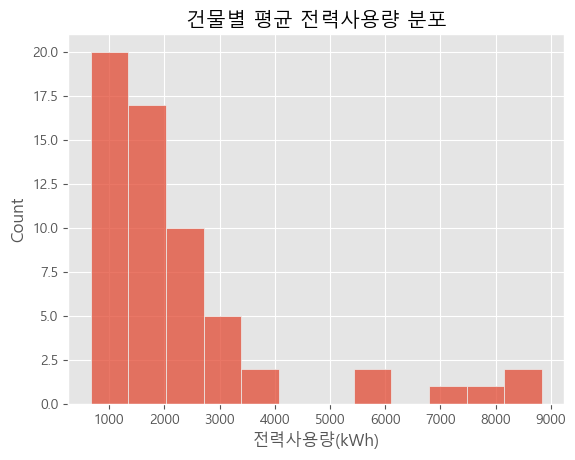

In [86]:
# 1. 건물별 '전력사용량' 평균 분포 시각화
sns.histplot(train_df.groupby('num')['전력사용량(kWh)'].mean())
plt.title('건물별 평균 전력사용량 분포')

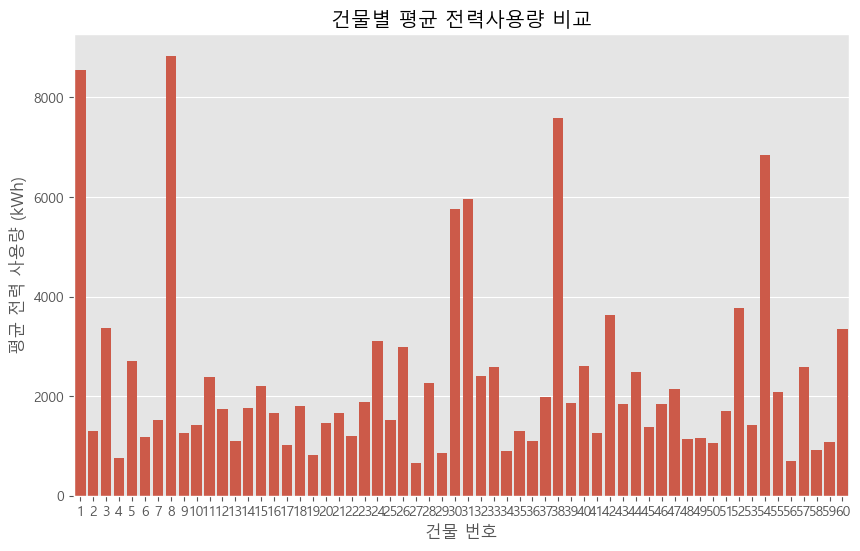

In [88]:
# 2. 건물별 평균 전력사용량 비교 시각화
mean_power_usage = train_df.groupby('num')['전력사용량(kWh)'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='num', y='전력사용량(kWh)', data=mean_power_usage)
plt.title('건물별 평균 전력사용량 비교')
plt.xlabel('건물 번호')
plt.ylabel('평균 전력 사용량 (kWh)')
plt.show()

In [121]:
# 주중, 주말 구분 열 추가
train_df['weekday'] = train_df['date_time'].dt.weekday
train_df['is_weekend'] = train_df['weekday'] >= 5

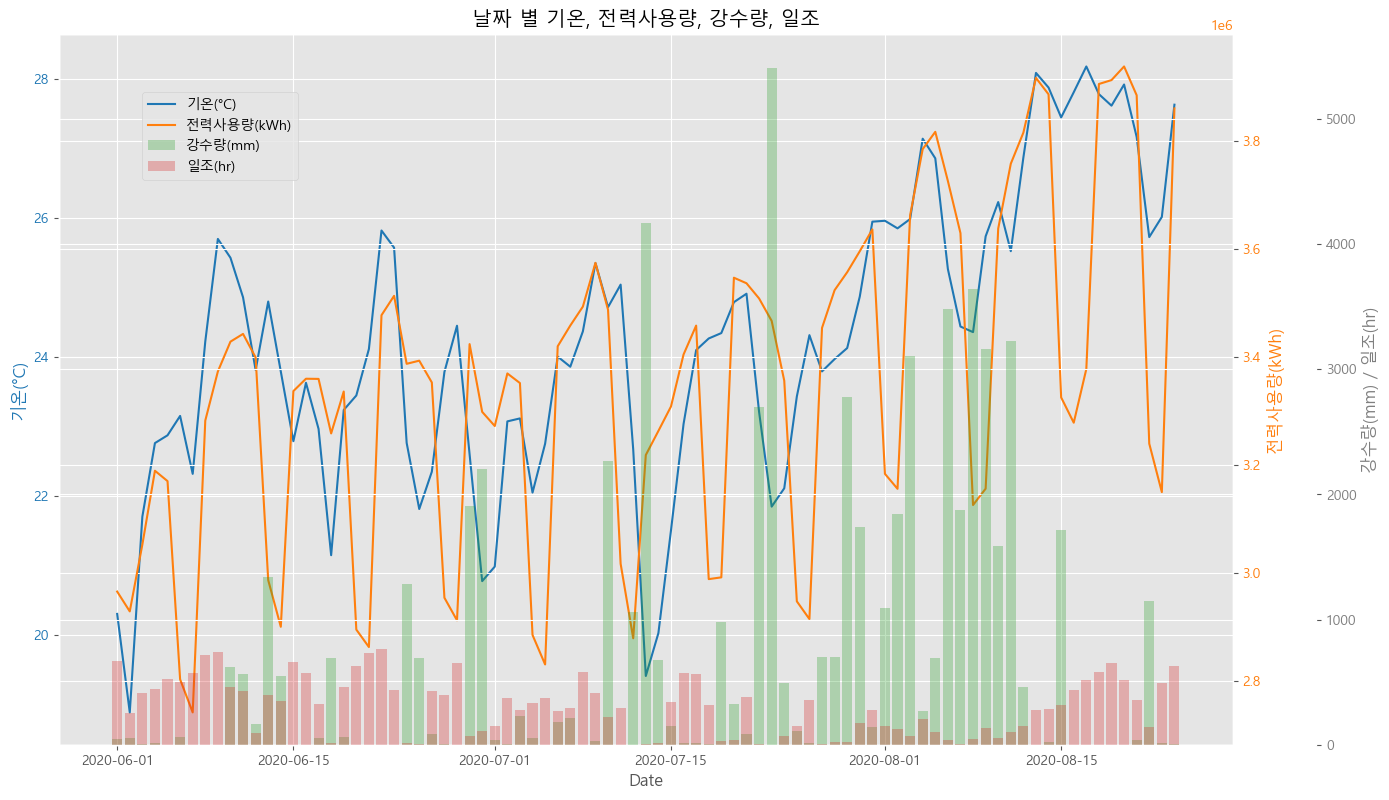

In [126]:
# 3. 전체 기간 : 기온, 전력사용량, 강수량, 일조량 동시 출력

train_df['date_time'] = pd.to_datetime(train_df['date_time'])

# 일별 데이터로 집계
daily_data = train_df.resample('D', on='date_time').agg({
    '전력사용량(kWh)': 'sum',
    '기온(°C)': 'mean',
    '강수량(mm)': 'sum',
    '일조(hr)': 'sum'
}).reset_index()

# 시각화
fig, ax1 = plt.subplots(figsize=(14, 8))

# 기온과 전력사용량을 선 그래프로 그리기
ax1.plot(daily_data['date_time'], daily_data['기온(°C)'], color='tab:blue', label='기온(°C)')
ax1.set_xlabel('Date')
ax1.set_ylabel('기온(°C)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(daily_data['date_time'], daily_data['전력사용량(kWh)'], color='tab:orange', label='전력사용량(kWh)')
ax2.set_ylabel('전력사용량(kWh)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# 강수량과 일조량을 막대 그래프로 그리기
ax3 = ax1.twinx()
ax3.bar(daily_data['date_time'], daily_data['강수량(mm)'], color='tab:green', alpha=0.3, label='강수량(mm)')
ax3.bar(daily_data['date_time'], daily_data['일조(hr)'], color='tab:red', alpha=0.3, label='일조(hr)')
ax3.set_ylabel('강수량(mm) / 일조(hr)', color='tab:gray')
ax3.tick_params(axis='y', labelcolor='tab:gray')
ax3.spines['right'].set_position(('outward', 60))

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

plt.title('날짜 별 기온, 전력사용량, 강수량, 일조')
plt.show()


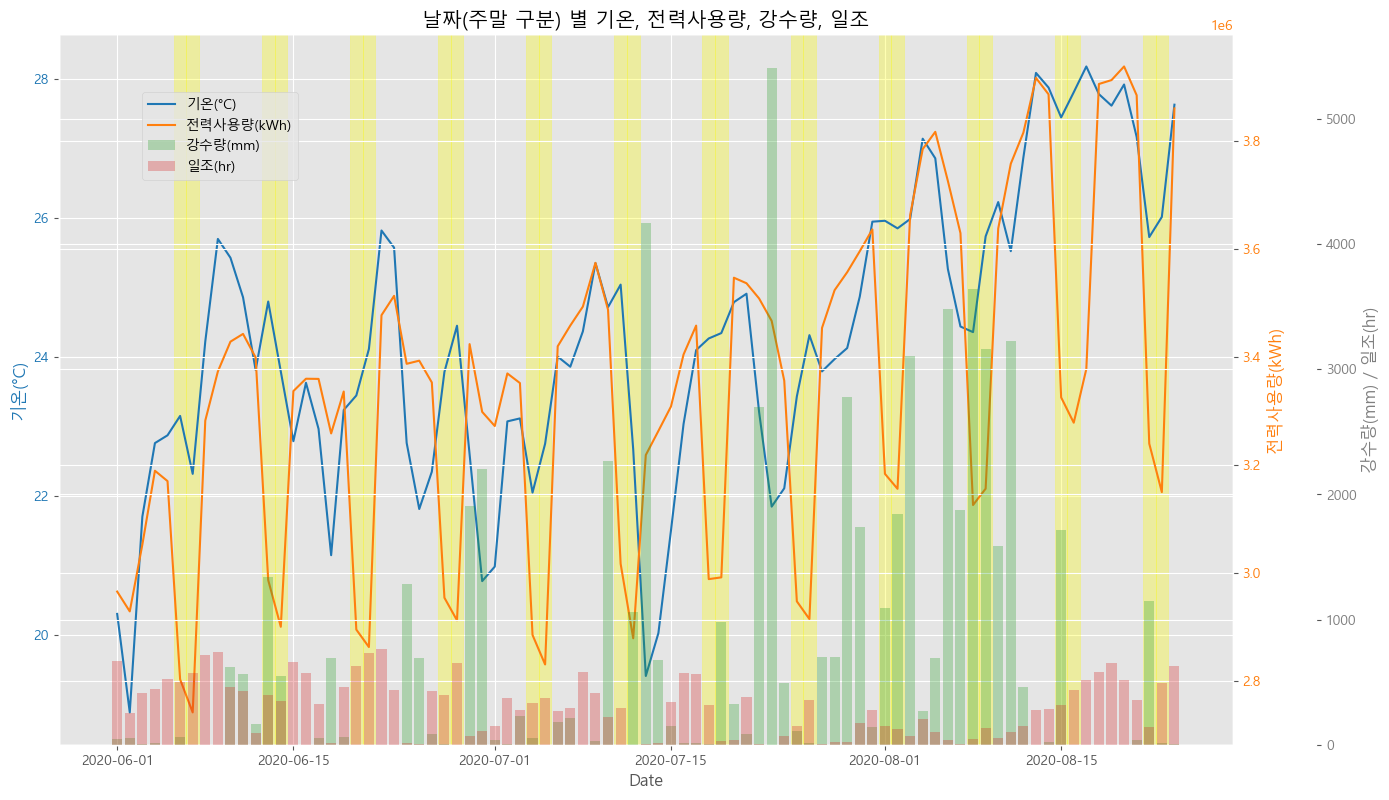

In [127]:
# 4. 주말 강조 표시 : 기온, 전력사용량, 강수량, 일조량 동시 출력
# 결과 해석
    # 전력 사용량은 주말을 제외하고 기온을 따라 상승
    # 기온이 떨어지는 구간은 강수량이 높은 구간으로, 이에 따라 전력 사용량도 감소하는 구간을 보임.

# 일별 데이터로 집계
daily_data = train_df.resample('D', on='date_time').agg({
    '전력사용량(kWh)': 'sum',
    '기온(°C)': 'mean',
    '강수량(mm)': 'sum',
    '일조(hr)': 'sum',
    'is_weekend': 'max'
}).reset_index()

# 시각화
fig, ax1 = plt.subplots(figsize=(14, 8))

# 기온과 전력사용량을 선 그래프로 그리기
ax1.plot(daily_data['date_time'], daily_data['기온(°C)'], color='tab:blue', label='기온(°C)')
ax1.set_xlabel('Date')
ax1.set_ylabel('기온(°C)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(daily_data['date_time'], daily_data['전력사용량(kWh)'], color='tab:orange', label='전력사용량(kWh)')
ax2.set_ylabel('전력사용량(kWh)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# 강수량과 일조량을 막대 그래프로 그리기
ax3 = ax1.twinx()
ax3.bar(daily_data['date_time'], daily_data['강수량(mm)'], color='tab:green', alpha=0.3, label='강수량(mm)')
ax3.bar(daily_data['date_time'], daily_data['일조(hr)'], color='tab:red', alpha=0.3, label='일조(hr)')
ax3.set_ylabel('강수량(mm) / 일조(hr)', color='tab:gray')
ax3.tick_params(axis='y', labelcolor='tab:gray')
ax3.spines['right'].set_position(('outward', 60))

# 주말 강조
for i, row in daily_data.iterrows():
    if row['is_weekend'] == 1:
        ax1.axvspan(row['date_time'] - pd.Timedelta(hours=12), row['date_time'] + pd.Timedelta(hours=12), color='yellow', alpha=0.3)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

plt.title('날짜(주말 구분) 별 기온, 전력사용량, 강수량, 일조')
plt.show()

### 1.2.2 전력사용량 기준

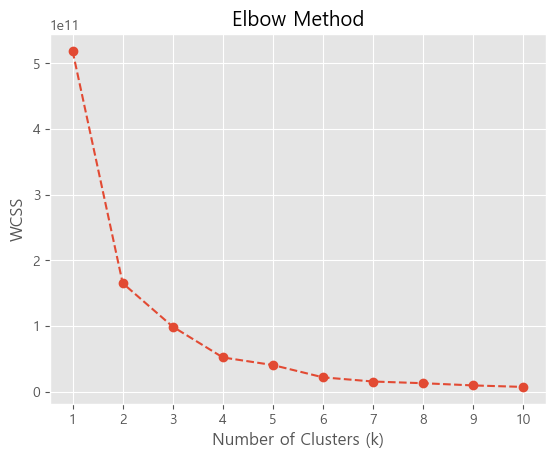

In [128]:
# 클러스터 개수(k)를 바꿔가며 WCSS(Within-Cluster Sum of Squares) 값 계산
wcss_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_df[['전력사용량(kWh)']])
    wcss_values.append(kmeans.inertia_)

# WCSS 값을 시각화하여 엘보우 그래프를 그립니다.
plt.plot(range(1, 11), wcss_values, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.show()

Cluster Summary:
   Cluster  Average Energy Consumption (kWh)  Number of Buildings  \
0        0                       1505.182916                   44   
1        3                       3392.344348                   11   
2        1                       6850.685585                    4   
3        2                       8543.273488                    1   

   Total Energy Consumption (kWh)  New_Cluster  
0                    13510.521853            0  
1                     7612.420716            1  
2                     5590.159437            2  
3                     1742.827792            3  

Updated DataFrame:
   num           date_time  전력사용량(kWh)  기온(°C)  풍속(m/s)  습도(%)  강수량(mm)  \
0    1 2020-06-01 00:00:00    8179.056    17.6      2.5   92.0      0.8   
1    1 2020-06-01 01:00:00    8135.640    17.7      2.9   91.0      0.3   
2    1 2020-06-01 02:00:00    8107.128    17.5      3.2   91.0      0.0   
3    1 2020-06-01 03:00:00    8048.808    17.1      3.2   91.0      0.0 

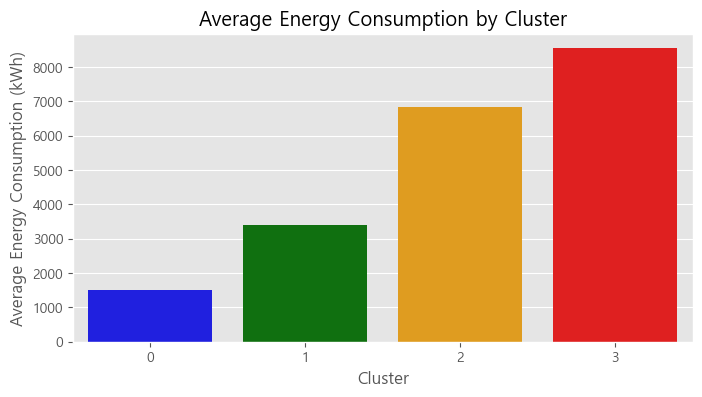

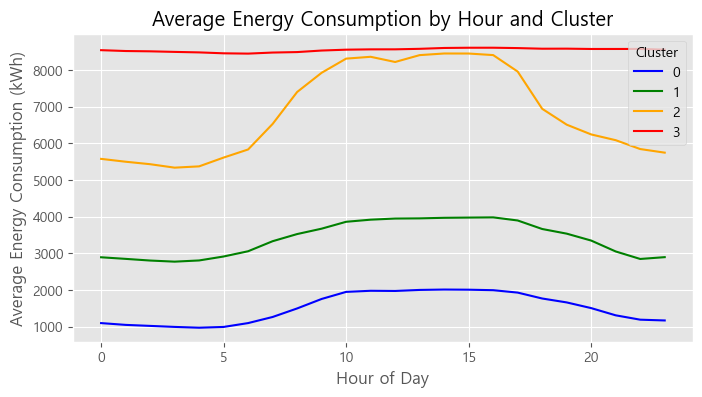

In [133]:
# 전력 사용량 기준 K-means, k=4, 전력사용량 낮은 순으로 클러스터 지정

# 전력 사용량만을 기준으로 클러스터링 수행
kmeans = KMeans(n_clusters=4, random_state=42)
train_df['km_cluster'] = kmeans.fit_predict(train_df[['전력사용량(kWh)']])

# 각 건물이 하나의 군집에만 속하도록 군집화 결과를 수정합니다.
eda_df_unique = train_df.groupby('num')['km_cluster'].first().reset_index()

# 군집화 결과를 기존 데이터프레임에 적용합니다.
train_df = pd.merge(train_df, eda_df_unique, on='num', suffixes=('', '_unique'))

# 기존 군집 열을 삭제하고 수정된 군집 열의 이름을 변경합니다.
train_df.drop(columns='km_cluster', inplace=True)
train_df.rename(columns={'km_cluster_unique': 'km_cluster'}, inplace=True)

# 군집별 평균 전력 사용량과 건물 개수 계산
cluster_means = train_df.groupby('km_cluster')['전력사용량(kWh)'].mean().reset_index()
cluster_counts = train_df.groupby('km_cluster')['num'].nunique().reset_index()

# 군집별 총 전력 사용량 계산 및 만단위로 변환
cluster_total_energy = train_df.groupby('km_cluster')['전력사용량(kWh)'].sum() / 10000
cluster_total_energy = cluster_total_energy.reset_index()

# 군집별 전력 사용량에 관한 정보를 담은 데이터프레임 생성
cluster_summary = pd.merge(cluster_means, cluster_counts, on='km_cluster')
cluster_summary = pd.merge(cluster_summary, cluster_total_energy, on='km_cluster')
cluster_summary.columns = ['Cluster', 'Average Energy Consumption (kWh)', 'Number of Buildings', 'Total Energy Consumption (kWh)']

# 전력 사용량 낮은 순으로 정렬
cluster_summary = cluster_summary.sort_values(by='Average Energy Consumption (kWh)').reset_index(drop=True)

# 새로운 클러스터 번호 할당
cluster_summary['New_Cluster'] = np.arange(len(cluster_summary))

# 원래 클러스터 번호와 새로운 클러스터 번호 매핑
cluster_mapping = cluster_summary.set_index('Cluster')['New_Cluster'].to_dict()

# 데이터프레임에 새로운 클러스터 번호 적용
train_df['km_cluster'] = train_df['km_cluster'].map(cluster_mapping)

# 출력
print("Cluster Summary:")
print(cluster_summary)
print()

# 데이터프레임 업데이트 후의 군집 정보 출력
print("Updated DataFrame:")
print(train_df.head())

# 'Cluster' 열 삭제
cluster_summary.drop(columns=['Cluster'], inplace=True)



# # =============================================
# 클러스터 별 색상 리스트 생성 (파랑, 초록, 주황, 빨강, 보라)
cluster_colors = ['blue', 'green', 'orange', 'red']

# 시각화: 군집별 평균 전력 사용량
plt.figure(figsize=(8, 4))
sns.barplot(data=cluster_summary, x='New_Cluster', y='Average Energy Consumption (kWh)', palette=cluster_colors)
plt.title('Average Energy Consumption by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Energy Consumption (kWh)')
plt.show()

# 시각화: 시간대별 평균 전력 사용량
train_df['date_time'] = pd.to_datetime(train_df['date_time'])
train_df['time'] = train_df['date_time'].dt.hour

hourly_means = train_df.groupby(['km_cluster', 'time'])['전력사용량(kWh)'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.lineplot(data=hourly_means, x='time', y='전력사용량(kWh)', hue='km_cluster', palette=cluster_colors)
plt.title('Average Energy Consumption by Hour and Cluster')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy Consumption (kWh)')
plt.legend(title='Cluster')
plt.show()

# # 군집별 건물 시각화
# for c in range(5):
#     cluster_data = train_df[train_df.km_cluster == c]
#     unique_nums = cluster_data['num'].unique()
#     n_nums = len(unique_nums)
#     fig, axes = plt.subplots(n_nums, 1, figsize=(20, 2*n_nums))
#     fig.suptitle(f'Cluster {c} Energy Usage Over Time', y=1.05, fontsize=16)

#     for i, num in enumerate(unique_nums):
#         building_data = cluster_data[cluster_data['num'] == num]
#         sns.lineplot(data=building_data, x='date_time', y='전력사용량(kWh)', ax=axes[i], color=cluster_colors[c], linewidth=0.5)
#         axes[i].set_title(f'Building {num}')
#         axes[i].set_ylabel('')
#         axes[i].set_xlabel('')

#     plt.tight_layout()
#     plt.subplots_adjust(hspace=1)
#     plt.show()

In [134]:
train_df

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,month,day,time,weekday,is_weekend,km_cluster
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6.0,1.0,0,0,False,3
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6.0,1.0,1,0,False,3
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6.0,1.0,2,0,False,3
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6.0,1.0,3,0,False,3
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6.0,1.0,4,0,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,8.0,24.0,19,0,False,1
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,8.0,24.0,20,0,False,1
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,8.0,24.0,21,0,False,1
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,8.0,24.0,22,0,False,1


In [136]:
# 각 건물의 이상치 탐지
for num in range(1, 61):
    building_data = train_df[train_df['num'] == num]
    q1 = building_data['전력사용량(kWh)'].quantile(0.25)
    q3 = building_data['전력사용량(kWh)'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = building_data[(building_data['전력사용량(kWh)'] < lower_bound) | (building_data['전력사용량(kWh)'] > upper_bound)]
    
    if not outliers.empty:
        print(f'Building {num} has {len(outliers)} outliers.')

Building 1 has 73 outliers.
Building 3 has 151 outliers.
Building 4 has 44 outliers.
Building 9 has 62 outliers.
Building 19 has 53 outliers.
Building 20 has 17 outliers.
Building 21 has 6 outliers.
Building 22 has 28 outliers.
Building 23 has 72 outliers.
Building 24 has 12 outliers.
Building 25 has 78 outliers.
Building 26 has 23 outliers.
Building 27 has 72 outliers.
Building 31 has 17 outliers.
Building 32 has 44 outliers.
Building 33 has 1 outliers.
Building 34 has 101 outliers.
Building 35 has 1 outliers.
Building 39 has 5 outliers.
Building 45 has 1 outliers.
Building 49 has 36 outliers.
Building 50 has 47 outliers.
Building 51 has 16 outliers.
Building 56 has 107 outliers.
Building 57 has 61 outliers.
Building 59 has 54 outliers.
Building 60 has 2 outliers.


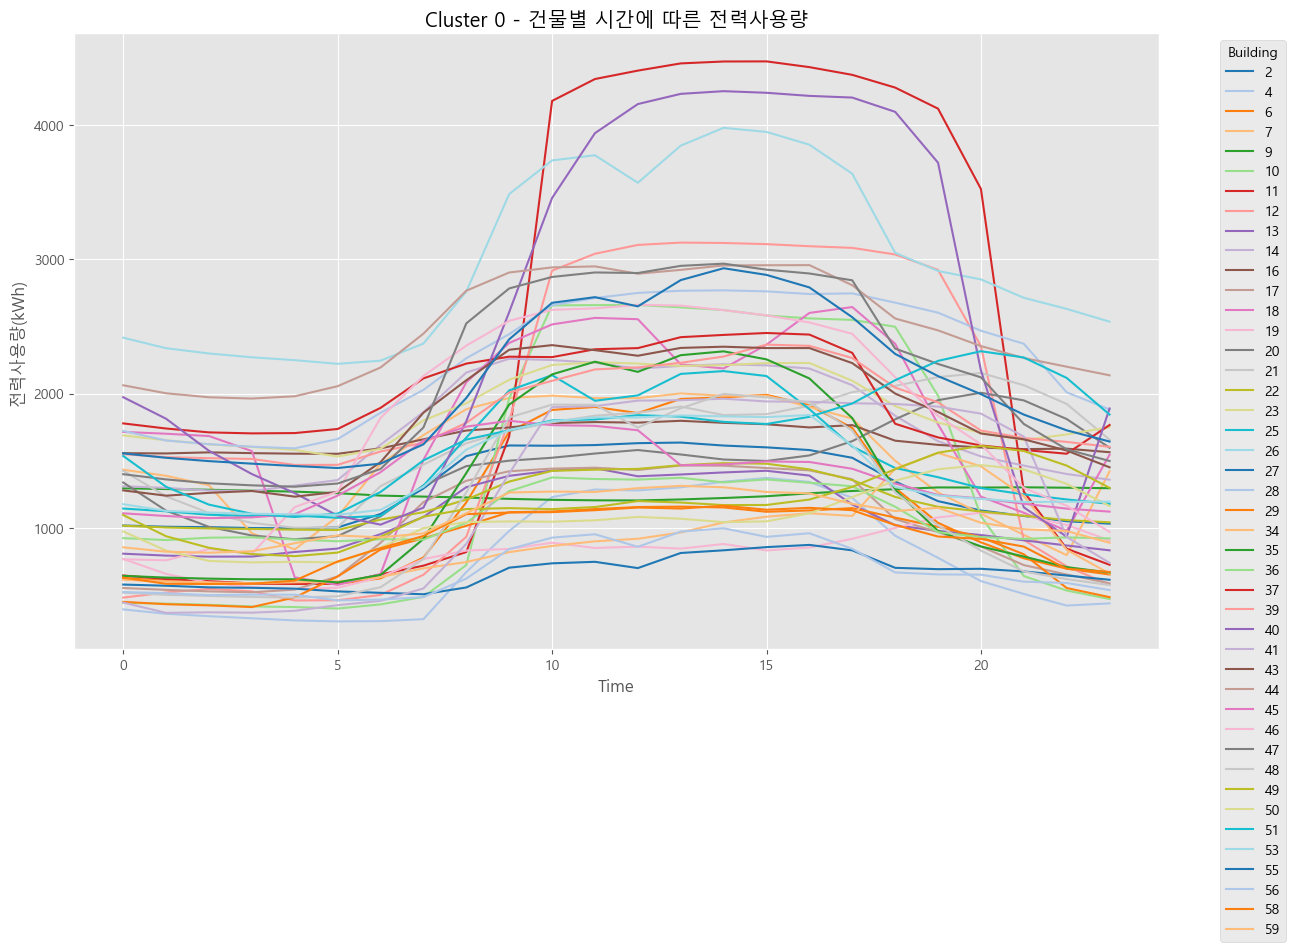

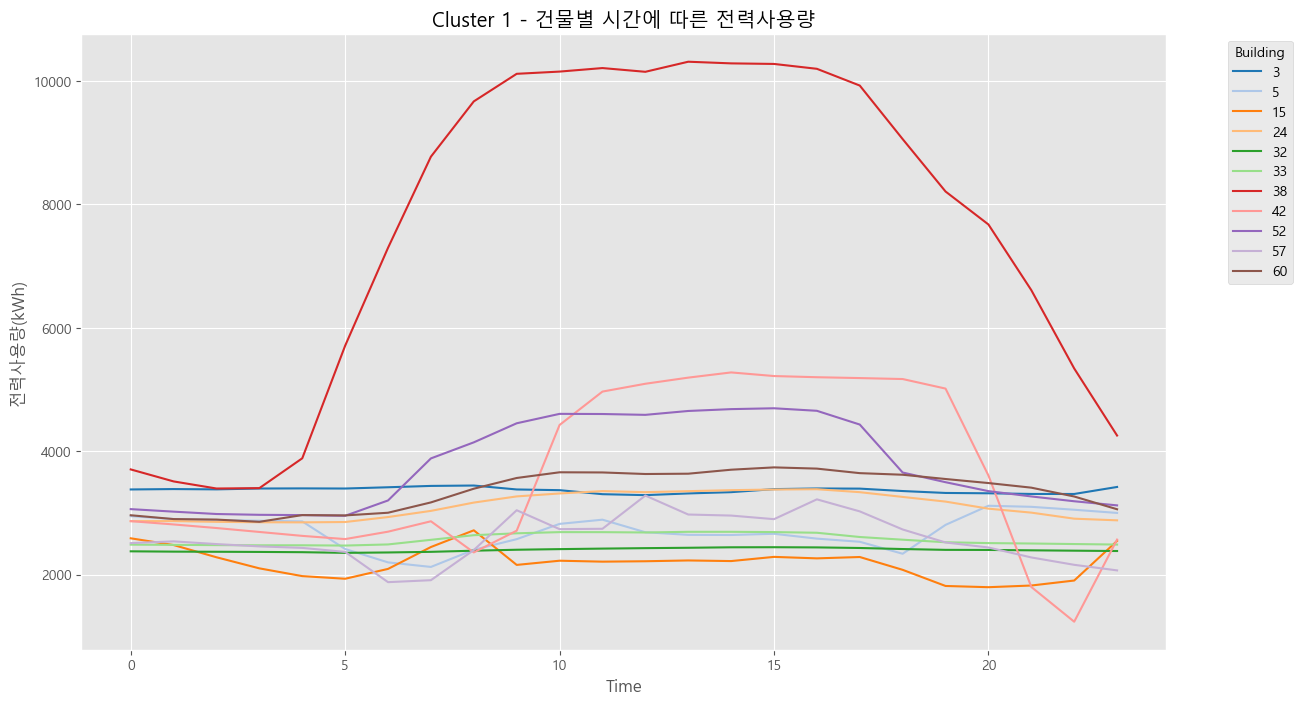

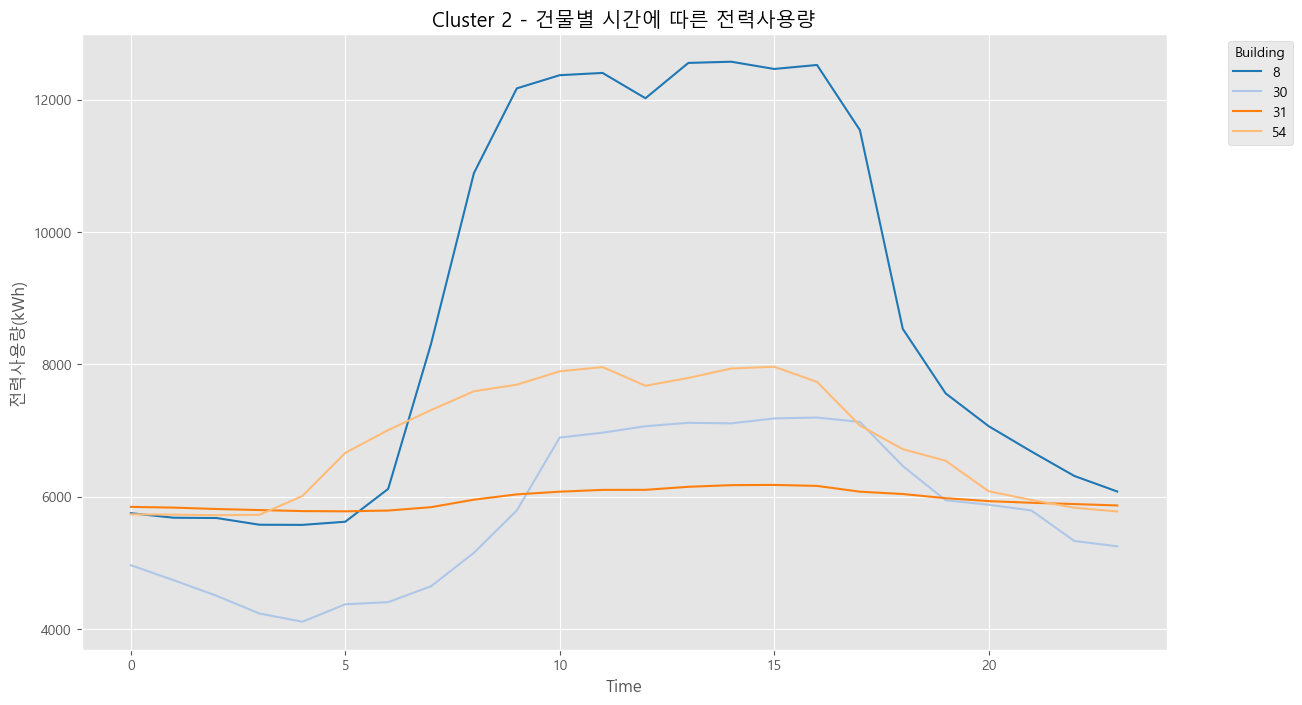

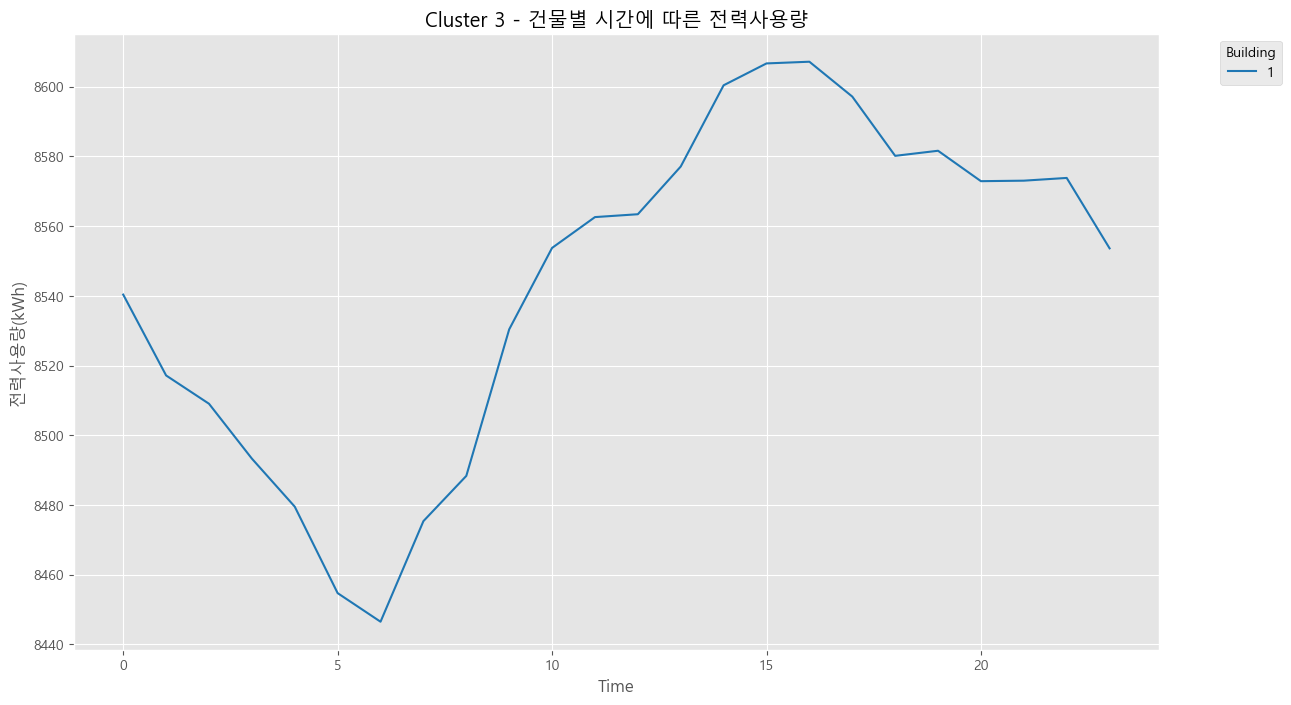

In [138]:
# 'datetime' 열 제외
data_for_clustering = train_df.drop(columns=['date_time'])


# 군집별 시간대별 평균 전력사용량 계산 및 시각화
for cluster in sorted(train_df['km_cluster'].unique()):  # 군집 순으로 정렬
    cluster_data = train_df[train_df['km_cluster'] == cluster]
    hourly_means = cluster_data.groupby(['num', 'time'])['전력사용량(kWh)'].mean().reset_index()
    
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=hourly_means, x='time', y='전력사용량(kWh)', hue='num', palette='tab20')
    plt.title(f'Cluster {cluster} - 건물별 시간에 따른 전력사용량(kWh)')
    plt.xlabel('Time')
    plt.ylabel('전력사용량(kWh)')
    plt.legend(title='Building', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

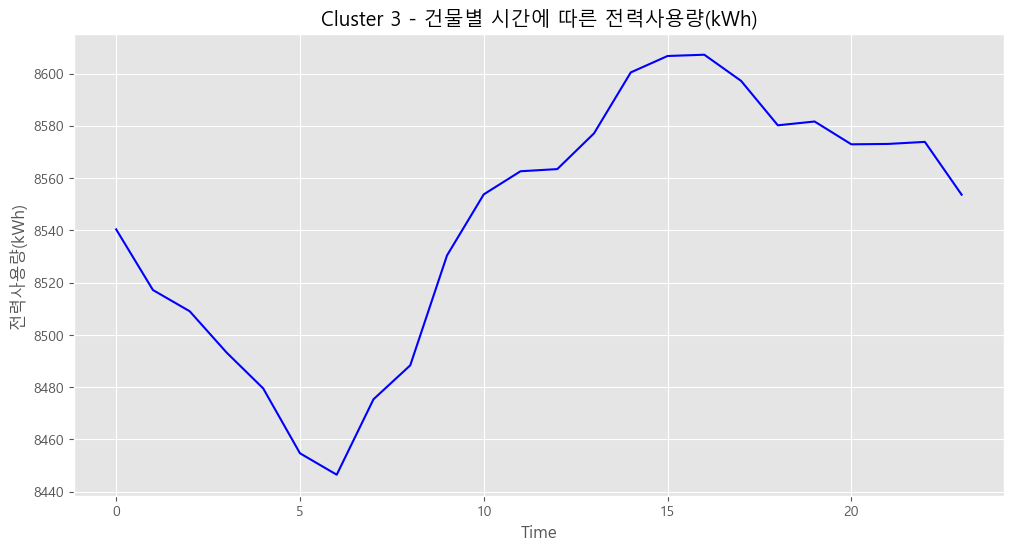

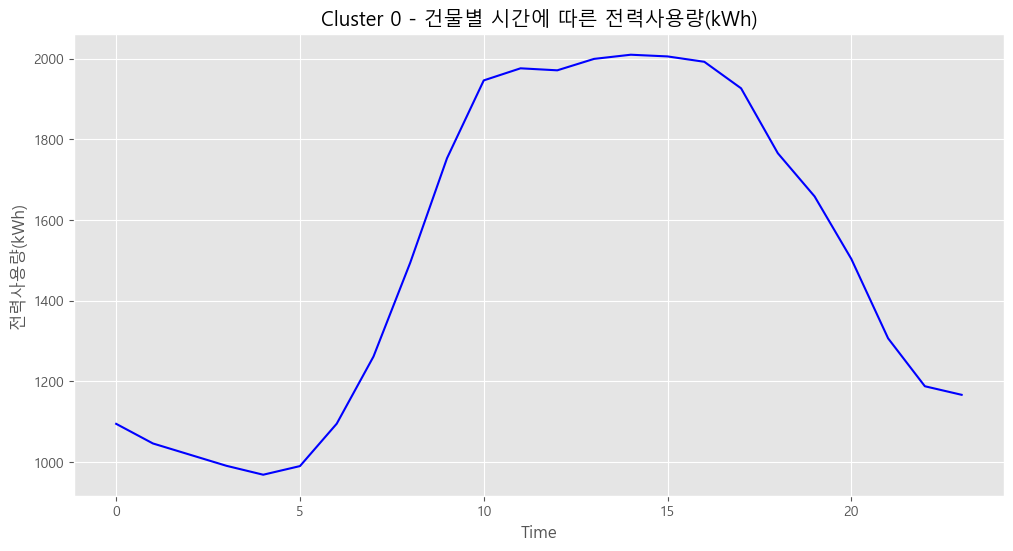

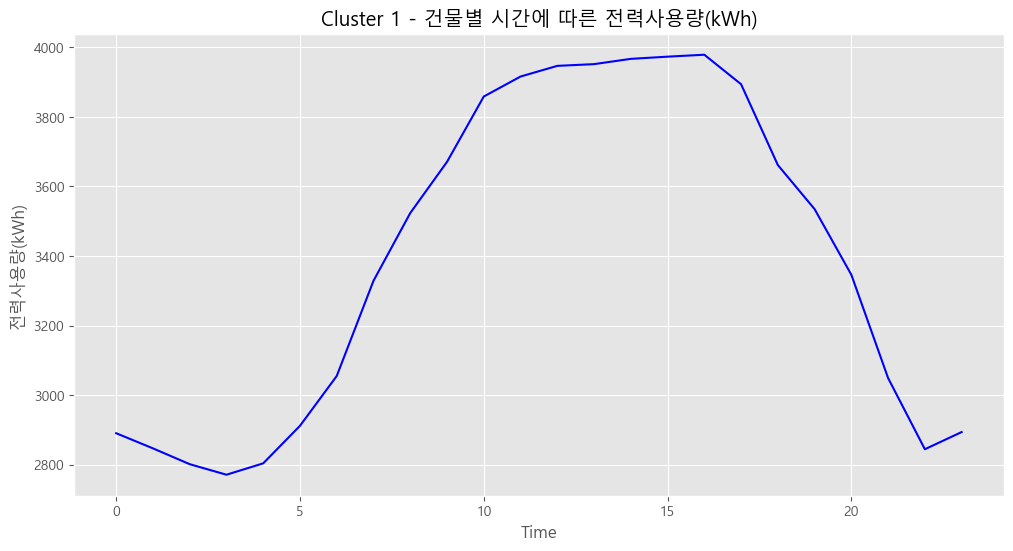

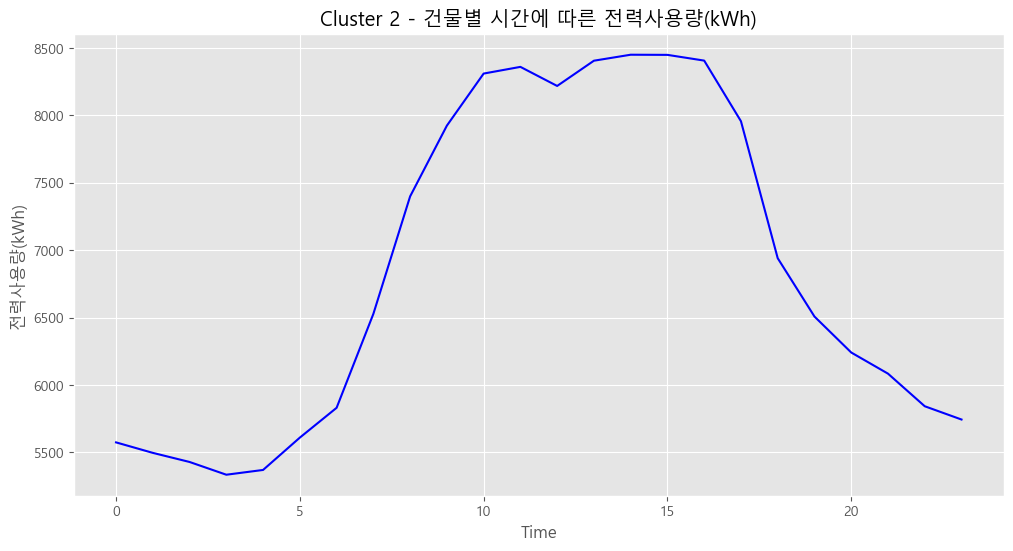

In [143]:
# 시간대별 평균 전력 사용량 계산
hourly_means = train_df.groupby(['km_cluster', 'time'])['전력사용량(kWh)'].mean().reset_index()

# 군집별 시간대별 평균 전력 사용량 시각화
for cluster in train_df['km_cluster'].unique():
    cluster_hourly_means = hourly_means[hourly_means['km_cluster'] == cluster]
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=cluster_hourly_means, x='time', y='전력사용량(kWh)', color='blue')
    plt.title(f'Cluster {cluster} - 건물별 시간에 따른 전력사용량(kWh)')
    plt.xlabel('Time')
    plt.ylabel('전력사용량(kWh)')
    plt.show()

[클러스터링 결과 해석]
- 클러스터 0 : 평균 전력 사용량이 비교적 낮고, 표준 편차가 크며, 최소값은 0으로 나타나 수요가 변동적인 특성을 보입니다.
- 클러스터 1 : 평균 전력 사용량이 중간 정도이며, 표준 편차가 다소 큽니다. 전력 사용량의 분포가 상대적으로 넓은 범위에 걸쳐 있습니다.
- 클러스터 2 : 평균 전력 사용량이 매우 높고, 표준 편차도 큰 편입니다. 상대적으로 매우 높은 전력 소비량을 보입니다.
- 클러스터 3 : 평균 전력 사용량이 평균적으로 높고, 표준 편차는 작으며, 최소값이 높은 편입니다. 전력 소비가 꾸준한 건물로 이루어져 있을 것으로 예상.

In [144]:
# 클러스터 순으로 건물별 전력 사용량 통계량 비교
cluster_statistics = train_df.groupby('km_cluster')['전력사용량(kWh)'].describe().sort_index()
print(cluster_statistics)

              count         mean          std        min        25%       50%  \
km_cluster                                                                      
0           89760.0  1505.182916   836.746241     0.0000   906.0660  1324.188   
1           22440.0  3392.344348  1767.721918   683.8128  2467.5840  2956.554   
2            8160.0  6850.685585  2572.793641  2285.2800  5695.4025  6038.064   
3            2040.0  8543.273488   130.265187  7784.4240  8486.0460  8555.868   

                 75%        max  
km_cluster                       
0           1897.344   5943.888  
1           3449.772  12824.280  
2           7143.957  17739.225  
3           8612.568   8827.704  


### 1.2.3 기후 조건 기준

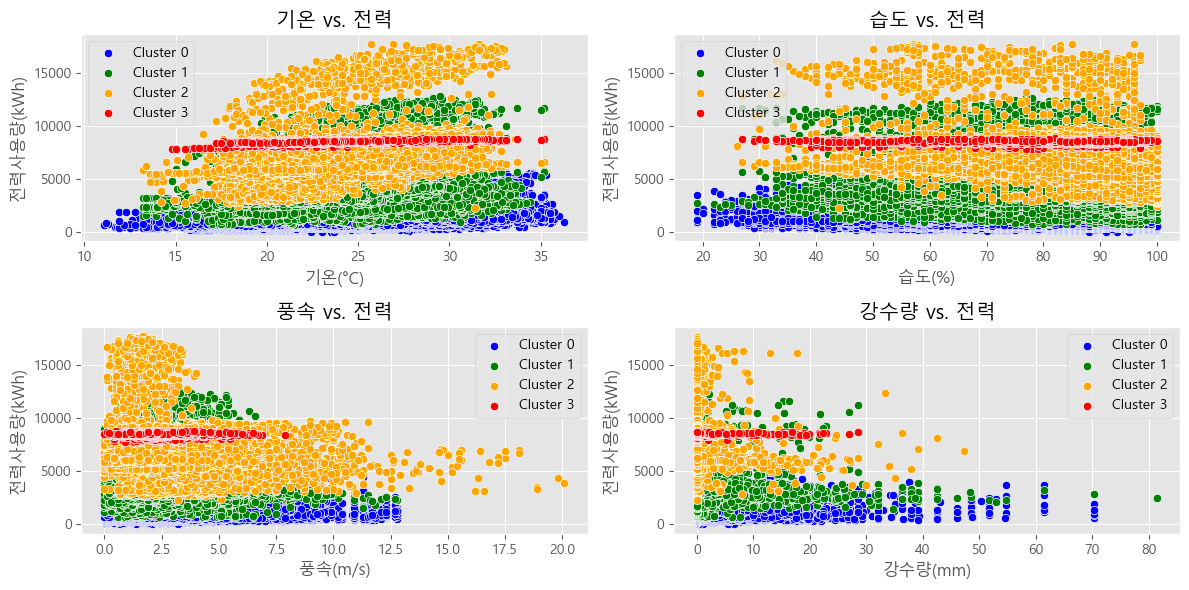

In [145]:
# 기후 조건과 전력 사용량 간의 관계 분석
plt.figure(figsize=(12, 6))

# 기온과 전력 사용량
plt.subplot(2, 2, 1)
for cluster, color in zip(sorted(train_df['km_cluster'].unique()), cluster_colors):
    cluster_data = train_df[train_df['km_cluster'] == cluster]
    sns.scatterplot(data=cluster_data, x='기온(°C)', y='전력사용량(kWh)', color=color, label=f'Cluster {cluster}')
plt.title('기온 vs. 전력')
plt.legend()

# 습도와 전력 사용량
plt.subplot(2, 2, 2)
for cluster, color in zip(sorted(train_df['km_cluster'].unique()), cluster_colors):
    cluster_data = train_df[train_df['km_cluster'] == cluster]
    sns.scatterplot(data=cluster_data, x='습도(%)', y='전력사용량(kWh)', color=color, label=f'Cluster {cluster}')
plt.title('습도 vs. 전력')
plt.legend()

# 풍속과 전력 사용량
plt.subplot(2, 2, 3)
for cluster, color in zip(sorted(train_df['km_cluster'].unique()), cluster_colors):
    cluster_data = train_df[train_df['km_cluster'] == cluster]
    sns.scatterplot(data=cluster_data, x='풍속(m/s)', y='전력사용량(kWh)', color=color, label=f'Cluster {cluster}')
plt.title('풍속 vs. 전력')
plt.legend()

# 강수량과 전력 사용량
plt.subplot(2, 2, 4)
for cluster, color in zip(sorted(train_df['km_cluster'].unique()), cluster_colors):
    cluster_data = train_df[train_df['km_cluster'] == cluster]
    sns.scatterplot(data=cluster_data, x='강수량(mm)', y='전력사용량(kWh)', color=color, label=f'Cluster {cluster}')
plt.title('강수량 vs. 전력')
plt.legend()

plt.tight_layout()
plt.show()

### 1.2.4 태양광/비전기냉방설비운영 유무 기준

#### 막대 그래프

In [90]:
# 태양광/비전기냉방설비운영 유무 확인
solar_electric_df = train_df.groupby(['비전기냉방설비운영','태양광보유'])['전력사용량(kWh)'].mean().reset_index()
solar_electric_df

,비전기냉방설비운영,태양광보유,전력사용량(kWh)
0,0.0,0.0,2077.030506
1,0.0,1.0,1582.298192
2,1.0,0.0,2101.993590
3,1.0,1.0,2949.726621


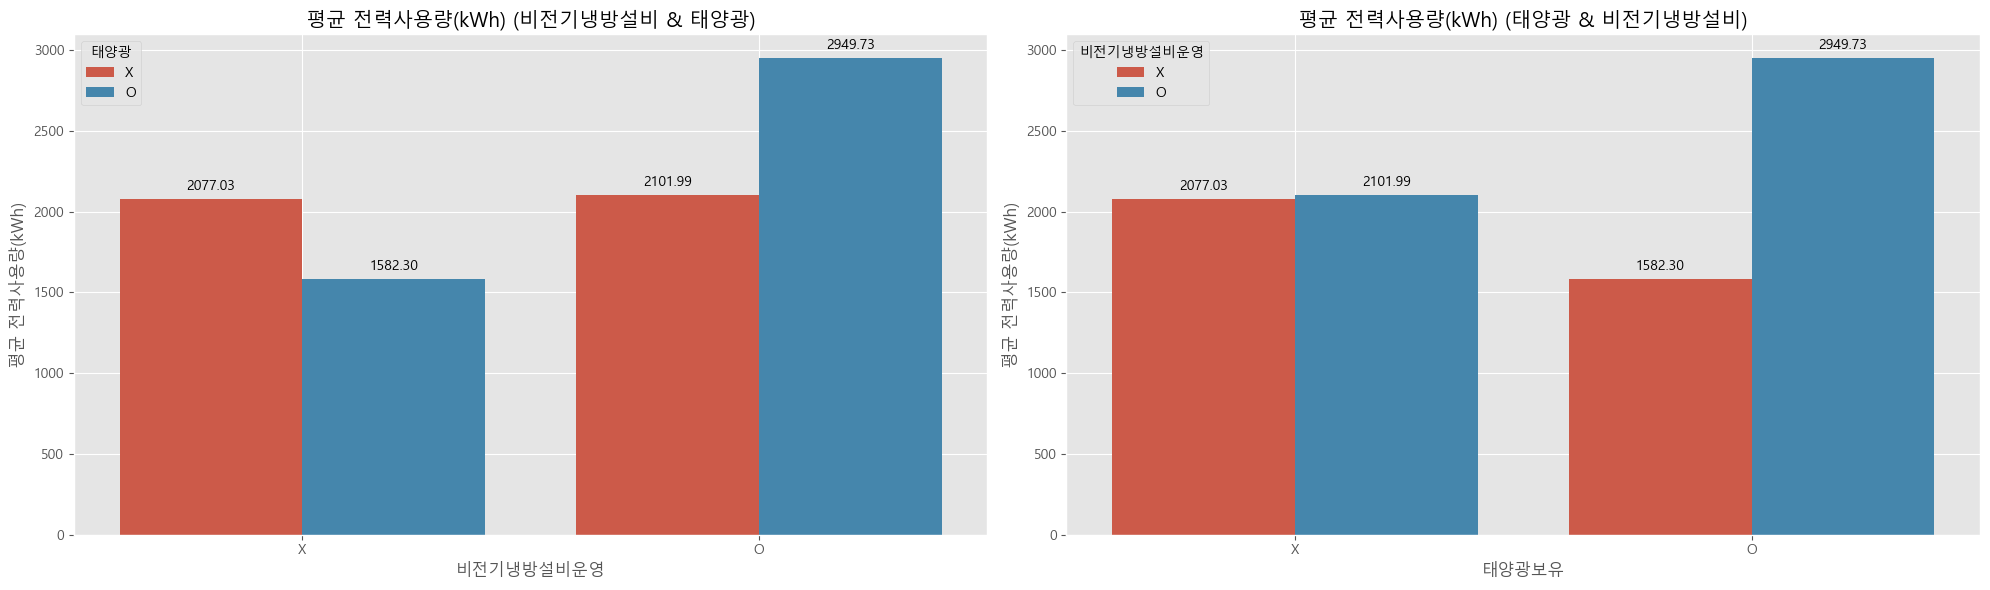

In [113]:
# '비전기냉방설비운영'과 '태양광보유'를 'X'와 'O'로 변환
solar_electric_df['비전기냉방설비운영'] = solar_electric_df['비전기냉방설비운영'].replace({0: 'X', 1: 'O'})
solar_electric_df['태양광보유'] = solar_electric_df['태양광보유'].replace({0: 'X', 1: 'O'})

plt.figure(figsize=(20, 6))

# 첫 번째 막대 그래프 : 비전기냉방설비운영
plt.subplot(1, 2, 1)
barplot1 = sns.barplot(data=solar_electric_df, x='비전기냉방설비운영', y='전력사용량(kWh)', hue='태양광보유')
# Bar 위에 통계량 추가
for p in barplot1.patches:
    height = p.get_height()
    if height != 0:  # 높이가 0이 아닌 경우에만 주석 추가
        barplot1.annotate(f'{height:.2f}',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='center',
                         xytext=(0, 9),
                         textcoords='offset points')

plt.title('평균 전력사용량(kWh) (비전기냉방설비 & 태양광)')
plt.xlabel('비전기냉방설비운영')
plt.ylabel('평균 전력사용량(kWh)')
plt.legend(title='태양광')
plt.grid(True)

# 두 번째 막대 그래프: 태양광보유
plt.subplot(1, 2, 2)
barplot2 = sns.barplot(data=solar_electric_df, x='태양광보유', y='전력사용량(kWh)', hue='비전기냉방설비운영')
# Bar 위에 통계량 추가
for p in barplot2.patches:
    height = p.get_height()
    if height != 0:  # 높이가 0이 아닌 경우에만 주석 추가
        barplot2.annotate(f'{height:.2f}',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='center',
                         xytext=(0, 9),
                         textcoords='offset points')

plt.title('평균 전력사용량(kWh) (태양광 & 비전기냉방설비)')
plt.xlabel('태양광보유')
plt.ylabel('평균 전력사용량(kWh)')
plt.legend(title='비전기냉방설비운영')
plt.grid(True)

# 그래프 출력
plt.tight_layout()
plt.show()

#### 시간별 총 전력사용량

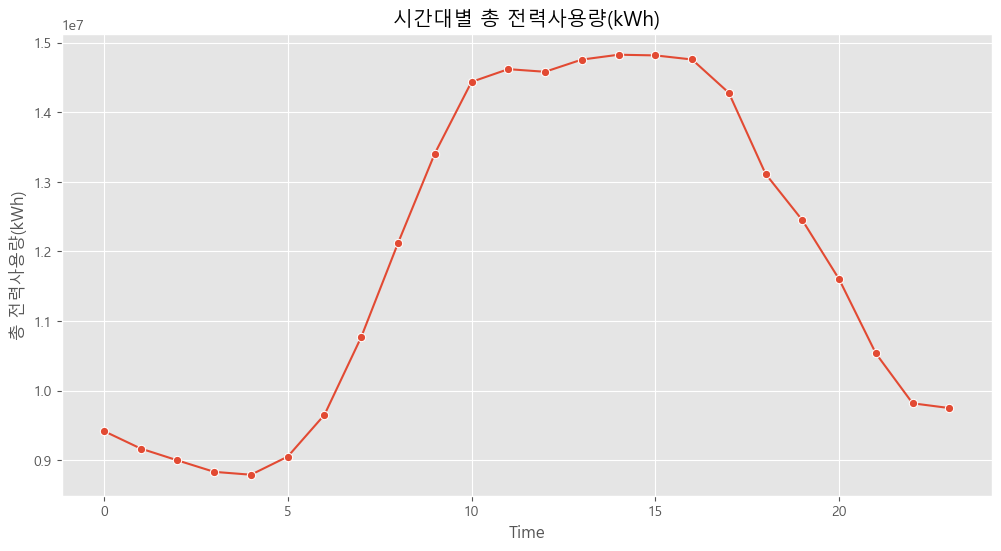

Total Energy Consumption by Building (sorted):
    num    전력사용량(kWh)
7     8  1.802822e+07
0     1  1.742828e+07
37   38  1.548091e+07
53   54  1.395327e+07
30   31  1.216721e+07
29   30  1.175290e+07
51   52  7.709893e+06
41   42  7.394168e+06
2     3  6.877562e+06
59   60  6.843735e+06
23   24  6.353866e+06
25   26  6.094885e+06
4     5  5.537600e+06
39   40  5.299907e+06
56   57  5.283545e+06
32   33  5.256051e+06
43   44  5.074681e+06
31   32  4.900977e+06
10   11  4.878400e+06
27   28  4.619722e+06
14   15  4.485905e+06
46   47  4.361430e+06
54   55  4.260146e+06
36   37  4.064729e+06
22   23  3.843717e+06
38   39  3.791050e+06
45   46  3.756721e+06
42   43  3.750606e+06
17   18  3.667178e+06
13   14  3.612057e+06
11   12  3.567661e+06
50   51  3.478280e+06
20   21  3.390671e+06
15   16  3.388090e+06
6     7  3.115362e+06
24   25  3.099127e+06
19   20  2.985595e+06
9    10  2.911415e+06
52   53  2.904809e+06
44   45  2.816417e+06
34   35  2.651912e+06
1     2  2.651825e+06
8     9

In [94]:
# 시간대별 총 전력 사용량 계산
hourly_total_energy = train_df.groupby('time')['전력사용량(kWh)'].sum().reset_index()

# 시간대별 총 전력 사용량 그래프
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_total_energy, x='time', y='전력사용량(kWh)', marker='o')
plt.title('시간대별 총 전력사용량(kWh)')
plt.xlabel('Time')
plt.ylabel('총 전력사용량(kWh)')
plt.grid(True)
plt.show()

# 각 건물 별 총 전력 사용량 계산 및 내림차순 정렬
building_total_energy = train_df.groupby('num')['전력사용량(kWh)'].sum().reset_index()
building_total_energy = building_total_energy.sort_values(by='전력사용량(kWh)', ascending=False)

# 각 건물 별 총 전력 사용량 출력
print("Total Energy Consumption by Building (sorted):")
print(building_total_energy)

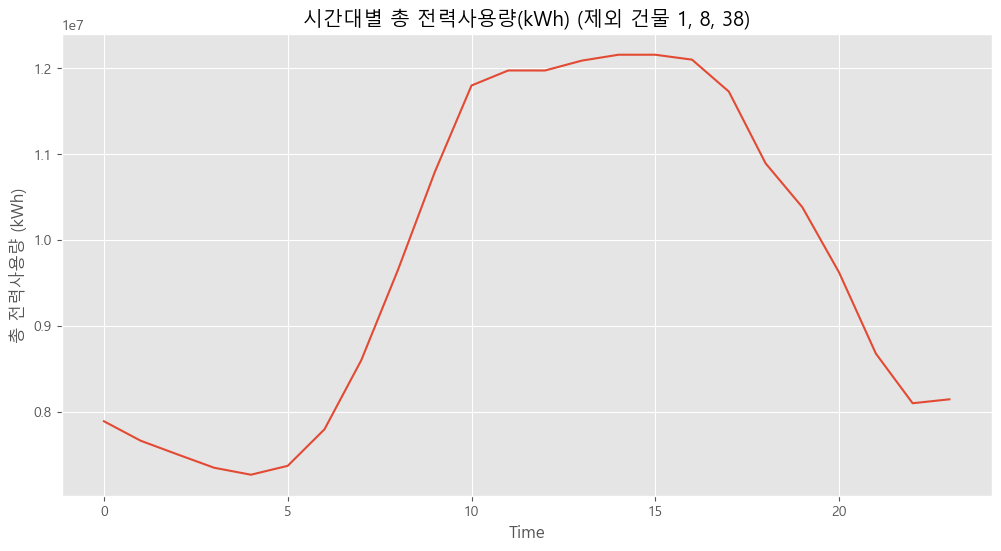

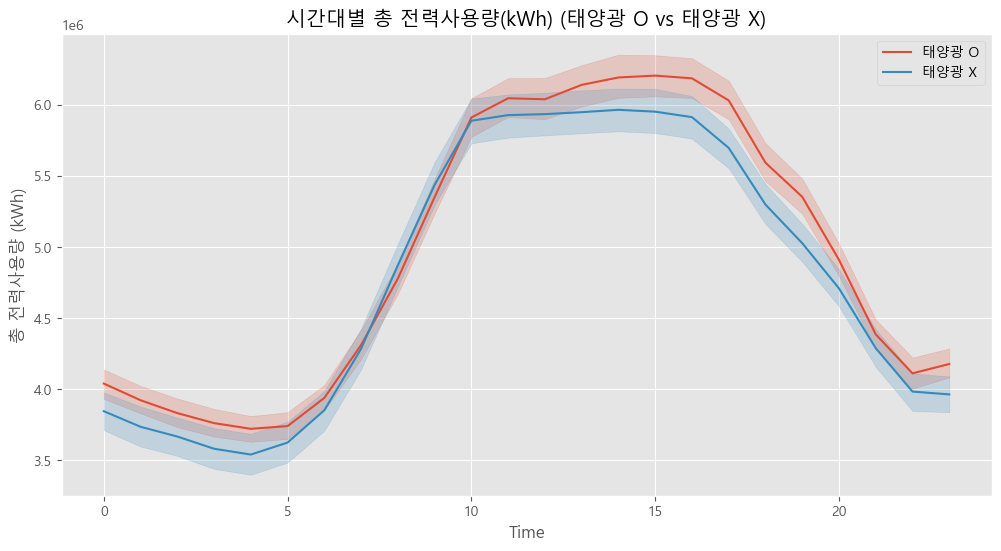

In [114]:
# 건물 1: 태양광 X, 건물 8, 38: 태양광 O
# 초고사용량 건물 1,8,38번을 제외

# 건물 1, 8, 38을 제외한 나머지 건물 선택
buildings_to_exclude = [1, 8, 38]
filtered_df = train_df[~train_df['num'].isin(buildings_to_exclude)].copy()

# 시간대별로 총 전력 사용량 계산
filtered_df['date_time'] = pd.to_datetime(filtered_df['date_time'])
filtered_df['time'] = filtered_df['date_time'].dt.hour

# 시간대별 총 전력 사용량 그래프 그리기
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='time', y='전력사용량(kWh)', estimator='sum', ci=None)
plt.title('시간대별 총 전력사용량(kWh) (제외 건물 1, 8, 38)')
plt.xlabel('Time')
plt.ylabel('총 전력사용량 (kWh)')
plt.grid(True)
plt.show()

#=====================================================
# 시간대별 총 전력 사용량을 태양광 발전량 여부에 따라 나누기
plt.figure(figsize=(12, 6))

# 태양광 발전량이 있는 건물의 시간대별 총 전력 사용량
sns.lineplot(data=filtered_df[filtered_df['태양광보유'] == 1], x='time', y='전력사용량(kWh)', estimator='sum', label='태양광 O')

# 태양광 발전량이 없는 건물의 시간대별 총 전력 사용량
sns.lineplot(data=filtered_df[filtered_df['태양광보유'] == 0], x='time', y='전력사용량(kWh)', estimator='sum', label='태양광 X')

plt.title('시간대별 총 전력사용량(kWh) (태양광 O vs 태양광 X)')
plt.xlabel('Time')
plt.ylabel('총 전력사용량 (kWh)')
plt.grid(True)
plt.legend()
plt.show()

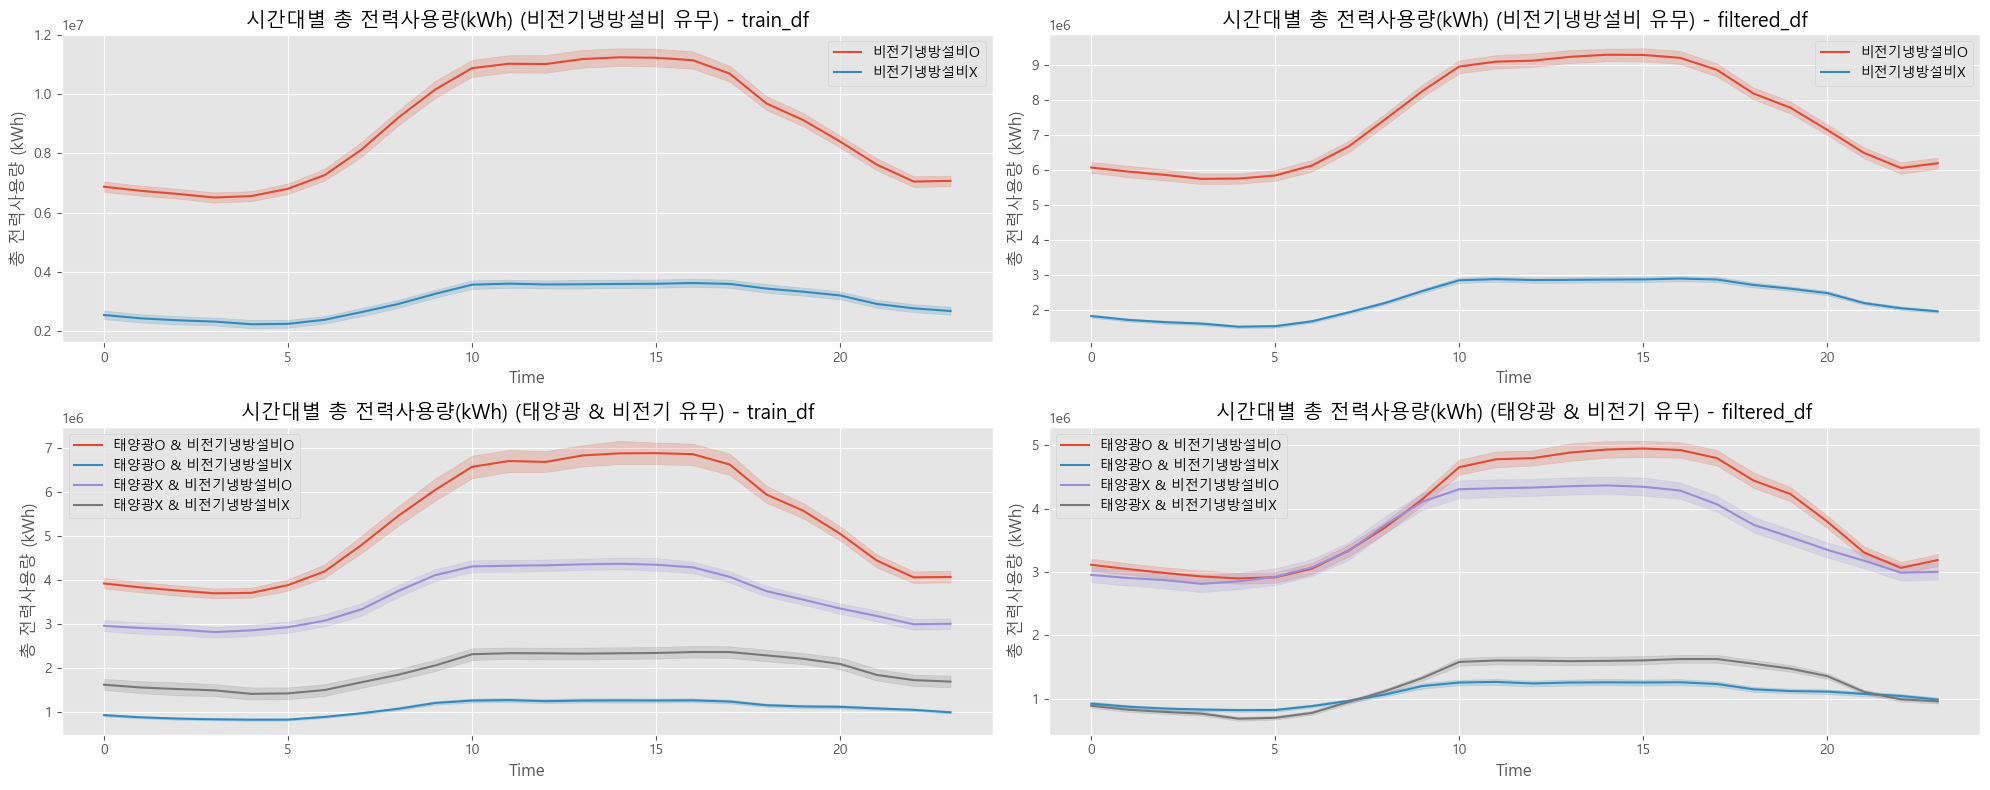

In [115]:
# 비전기냉방시설 유무에 따라 유의미한 차이 확인
# 초고사용량 건물 1,8,38번을 제외하면 확연한 차이 확인가능

plt.figure(figsize=(20, 8))

# 첫 번째 그래프: 비전기냉방설비운영 여부에 따른 전력 사용량 그래프 (train_df)
plt.subplot(2, 2, 1)
sns.lineplot(data=train_df[train_df['비전기냉방설비운영'] == 1], x='time', y='전력사용량(kWh)', estimator='sum', label='비전기냉방설비O')
sns.lineplot(data=train_df[train_df['비전기냉방설비운영'] == 0], x='time', y='전력사용량(kWh)', estimator='sum', label='비전기냉방설비X')
plt.title('시간대별 총 전력사용량(kWh) (비전기냉방설비 유무) - train_df')
plt.xlabel('Time')
plt.ylabel('총 전력사용량 (kWh)')
plt.grid(True)
plt.legend()

# 두 번째 그래프: 비전기냉방설비운영 여부에 따른 전력 사용량 그래프 (filtered_df)
plt.subplot(2, 2, 2)
sns.lineplot(data=filtered_df[filtered_df['비전기냉방설비운영'] == 1], x='time', y='전력사용량(kWh)', estimator='sum', label='비전기냉방설비O')
sns.lineplot(data=filtered_df[filtered_df['비전기냉방설비운영'] == 0], x='time', y='전력사용량(kWh)', estimator='sum', label='비전기냉방설비X')
plt.title('시간대별 총 전력사용량(kWh) (비전기냉방설비 유무) - filtered_df')
plt.xlabel('Time')
plt.ylabel('총 전력사용량 (kWh)')
plt.grid(True)
plt.legend()

# 세 번째 그래프: 태양광 및 비전기 여부에 따른 전력 사용량 그래프 (train_df)
plt.subplot(2, 2, 3)
sns.lineplot(data=train_df[(train_df['태양광보유'] == 1) & (train_df['비전기냉방설비운영'] == 1)], x='time', y='전력사용량(kWh)', estimator='sum', label='태양광O & 비전기냉방설비O')
sns.lineplot(data=train_df[(train_df['태양광보유'] == 1) & (train_df['비전기냉방설비운영'] == 0)], x='time', y='전력사용량(kWh)', estimator='sum', label='태양광O & 비전기냉방설비X')
sns.lineplot(data=train_df[(train_df['태양광보유'] == 0) & (train_df['비전기냉방설비운영'] == 1)], x='time', y='전력사용량(kWh)', estimator='sum', label='태양광X & 비전기냉방설비O')
sns.lineplot(data=train_df[(train_df['태양광보유'] == 0) & (train_df['비전기냉방설비운영'] == 0)], x='time', y='전력사용량(kWh)', estimator='sum', label='태양광X & 비전기냉방설비X')
plt.title('시간대별 총 전력사용량(kWh) (태양광 & 비전기 유무) - train_df')
plt.xlabel('Time')
plt.ylabel('총 전력사용량 (kWh)')
plt.grid(True)
plt.legend()

# 네 번째 그래프: 태양광 및 비전기 여부에 따른 전력 사용량 그래프 (filtered_df)
plt.subplot(2, 2, 4)
sns.lineplot(data=filtered_df[(filtered_df['태양광보유'] == 1) & (filtered_df['비전기냉방설비운영'] == 1)], x='time', y='전력사용량(kWh)', estimator='sum', label='태양광O & 비전기냉방설비O')
sns.lineplot(data=filtered_df[(filtered_df['태양광보유'] == 1) & (filtered_df['비전기냉방설비운영'] == 0)], x='time', y='전력사용량(kWh)', estimator='sum', label='태양광O & 비전기냉방설비X')
sns.lineplot(data=filtered_df[(filtered_df['태양광보유'] == 0) & (filtered_df['비전기냉방설비운영'] == 1)], x='time', y='전력사용량(kWh)', estimator='sum', label='태양광X & 비전기냉방설비O')
sns.lineplot(data=filtered_df[(filtered_df['태양광보유'] == 0) & (filtered_df['비전기냉방설비운영'] == 0)], x='time', y='전력사용량(kWh)', estimator='sum', label='태양광X & 비전기냉방설비X')
plt.title('시간대별 총 전력사용량(kWh) (태양광 & 비전기 유무) - filtered_df')
plt.xlabel('Time')
plt.ylabel('총 전력사용량 (kWh)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### 1.2.5 시간/주말/주중 구분

### 1.2.6 피크타임 확인

## 1.3 시계열 분해 : ACF, PACF, CCF

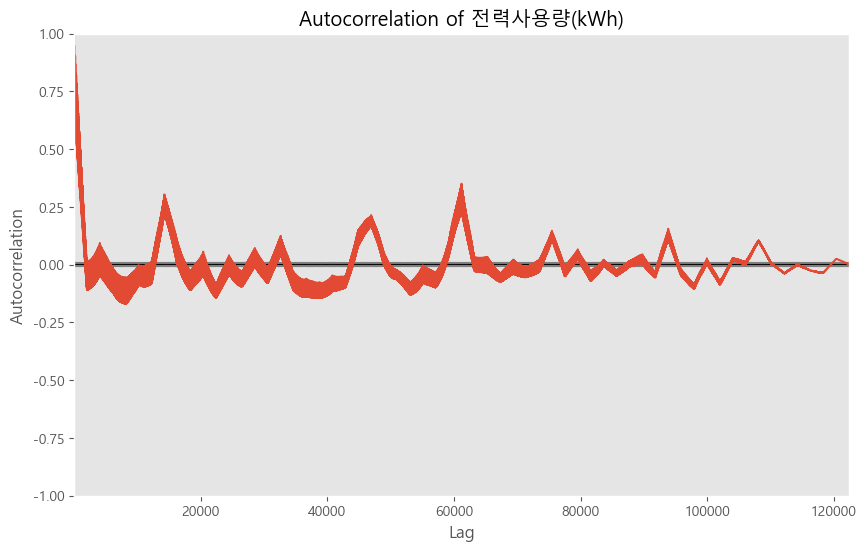

In [53]:
# ACF(Autocorrelation Function, 자기상관함수) 시각화
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

# 'date_time' 인덱스로 설정
train_df.set_index('date_time', inplace=True)

# '전력사용량(kWh)'열을 autocorrelation(자기상관) 시각화
plt.figure(figsize=(10, 6))
autocorrelation_plot(train_df['전력사용량(kWh)'])
plt.title('Autocorrelation of 전력사용량(kWh)')
plt.show()

# 2. 모델 탐색⭐️

## 2-1. ARIMA

## 2-2. LSTM

## 2-3. LGBM

## 2-4. XGBoost